In [1]:
from typing import Optional, Tuple, Union

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from master_thesis.utils.loading import ConnectivityDataset, get_balanced_train_test_masks
from master_thesis.utils.plotting import plot_confusion_matrix

# Constants and hyperparameters

In [2]:
# Constants
SEED = 42
EC_DATASET_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicks/networks"
CAUSAL_COEFF_THRESHOLD = 0.5

# Hyperparameters
HALF_TEST_SIZE = 16
N_BINS = 10
# EPOCHS = 100
# BATCH_SIZE = 32
# LEARNING_RATE = 2e-3
# WEIGHT_DECAY = 5e-4
# NUM_LAYERS = 2
# HIDDEN_SIZE = 16

# Data handling

## Load effective connectivity data

In [3]:
networks = np.array(os.listdir(EC_DATASET_PATH))
labels = np.array([np_file[4:7] == 'PAT' for np_file in networks])

train_mask, test_mask = get_balanced_train_test_masks(labels, half_test_size=HALF_TEST_SIZE, seed=SEED)

## Aggregate LDPs

In [11]:
def get_ldps(dataset: ConnectivityDataset) -> Tuple[np.ndarray, np.ndarray]:

    def aggregate_ldp(data: Data) -> np.ndarray:
        ldp = data.x[:, 1:]
        x = [np.histogram(ldp[:, i], bins=N_BINS, density=True)[0] for i in range(5)]
        return np.concatenate(x, axis=0)
    
    xs = []
    ys = []
    for data in dataset:
        x = aggregate_ldp(data)
        xs.append(x)
        ys.append(data.y.item())
    xs = np.stack(xs, axis=0)
    ys = np.array(ys)

    return xs, ys

## Train/test split

In [12]:
train_dataset = ConnectivityDataset(EC_DATASET_PATH, networks_mask=train_mask, causal_coeff_threshold=0.5, ldp=True)
test_dataset = ConnectivityDataset(EC_DATASET_PATH, networks_mask=test_mask, causal_coeff_threshold=0.5, ldp=True)

xs_train, ys_train = get_ldps(train_dataset)
xs_test, ys_test = get_ldps(test_dataset)

## Model training

In [51]:
# model = RandomForestClassifier(
#     n_estimators=1,
#     criterion="gini",
#     max_features="sqrt",
#     n_jobs=-1,
#     random_state=0,
# )

# model = LinearSVC(
#     penalty="l2",
#     loss="hinge",
#     max_iter=10000,
#     random_state=0,
# )

# model = SVC(
#     kernel="rbf",
#     cache_size=1024,
#     random_state=0,
#     C=1.
# )

model = MLPClassifier(
    hidden_layer_sizes=(4, 4),
    activation="relu",
    solver="adam",
    alpha=0.0,
    batch_size="auto",
    learning_rate="constant",
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=0,
)

In [52]:
model.fit(xs_train, ys_train)

/Users/wciezobka/venvs/sano/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.0, hidden_layer_sizes=(4, 4), max_iter=1000,
              random_state=0)

In [53]:
ys_hat_train = model.predict(xs_train)
ys_hat_test = model.predict(xs_test)

## Model evaluation

In [54]:
def evaluate_model(ys_gold: np.ndarray, ys_hat: np.ndarray) -> Tuple[float, float, float, float, float]:
    
    accuracy = accuracy_score(ys_gold, ys_hat)
    precision = precision_score(ys_gold, ys_hat)
    recall = recall_score(ys_gold, ys_hat)
    f1 = f1_score(ys_gold, ys_hat)
    auc = roc_auc_score(ys_gold, ys_hat)

    return accuracy, precision, recall, f1, auc

In [59]:
np_2d = np.reshape(np.arange(0, 50), (5, 10))
np_flatten = np_2d.flatten()
np_flatten

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Train
Accuracy: 0.9052197802197802
Precision: 0.9483282674772037
Recall: 0.8571428571428571
F1: 0.9004329004329005
AUC: 0.9052197802197802

Test
Accuracy: 0.59375
Precision: 0.56
Recall: 0.875
F1: 0.6829268292682927
AUC: 0.59375


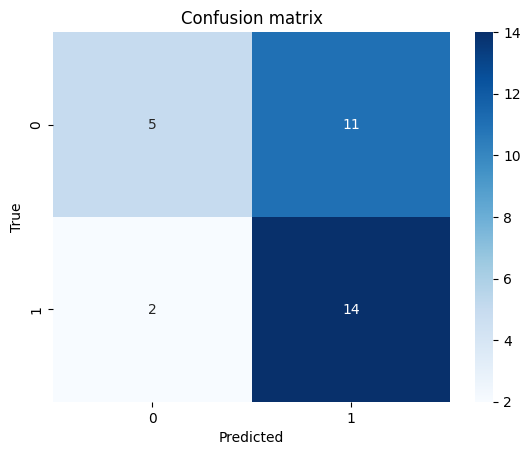

In [55]:
# Train metrics
print("Train")
print(f"Accuracy: {accuracy_score(ys_train, ys_hat_train)}")
print(f"Precision: {precision_score(ys_train, ys_hat_train)}")
print(f"Recall: {recall_score(ys_train, ys_hat_train)}")
print(f"F1: {f1_score(ys_train, ys_hat_train)}")
print(f"AUC: {roc_auc_score(ys_train, ys_hat_train)}")

# Test metrics
print("\nTest")
print(f"Accuracy: {accuracy_score(ys_test, ys_hat_test)}")
print(f"Precision: {precision_score(ys_test, ys_hat_test)}")
print(f"Recall: {recall_score(ys_test, ys_hat_test)}")
print(f"F1: {f1_score(ys_test, ys_hat_test)}")
print(f"AUC: {roc_auc_score(ys_test, ys_hat_test)}")

# Plot confusion matrix
plot_confusion_matrix(ys_test, ys_hat_test, save_path="/Users/wciezobka/Downloads/ldp_confusion_matrix.png")